In [1]:
# 1

########### 28 June 2021 ##########
######### Alec Hirschauer #########
#
# In this notebook, we will be creating the LAMPTAB file(s)
# for the G130M 1291, 1300, 1309, 1318, and 1321 cenwaves at LP5,
# plus the G140L 800 cenwave at LP3.
#
# This is an all-in-one notebook combining the work from two
# previous notebooks from 22 April 2021 and 14 June 2021
# which focus on G140L/c800 and G130M, respectively.
#
# Elaine helped me out a TON with this, so thank you!


In [2]:
# 2

# The first thing we need to do is import the relevant packages.

import calcos
from astropy.io import fits
import glob
import numpy as np

# Obviously we'll need CalCOS to process the COS data, but also
# astropy's fits to handle the .fits files, glob (which allows for
# manipulating data with similar file names), and numpy to do some
# sorting of the data based on .fits file header information.


In [3]:
# 3

# In my directory with all my data, I want to specify only some files
# to work on, from the vast assortment of files (I downloaded both the
# raw files and the processed files; clearly all we really need here are
# the unprocessed, raw files).
#
# Set a variable called "rawtags" with glob to specify only the files in
# this working directory that have the word "rawtag" in it:

rawtags = glob.glob('*_rawtag_*.fits')


In [4]:
# 4

# From here, we can print out a list of the files set by the command above,

#print(rawtags)

# or print out the whole header of the first file (index[0]),

#fits.getheader(rawtags[0])

# but the next *useful* thing to do is set a consistent 'RANDSEED' value
# for every rawtag file, which will be used for important things later on.

for myfile in rawtags:
    fits.setval(myfile, 'RANDSEED', value=123456789)
    
# This dinky for loop takes all the files defined by "rawtags", then uses
# the astropy fits package to set a value for 'RANDSEED' to the very creative
# value of 123456789.
#
# (Note: "myfile" in this case specifies the very last file set by "rawtags".)


In [5]:
# 5

# We can print out the 'RANDSEED' value to show that the last command did its job,

#fits.getval(myfile, 'RANDSEED')

# but that's only if you really need to prove it to yourself.

# What we need to do now, as stipulated in the ISRs for similar work done, is to
# set the various fits header parameters to what they need to be for when we run
# them through CalCOS, in order for them to run the way we want them to.

for myfile in rawtags:
    if fits.getval(myfile, 'OPT_ELEM') == 'G140L':
        fits.setval(myfile, 'FLATCORR', value='PERFORM')
        fits.setval(myfile, 'WAVECORR', value='OMIT')
        fits.setval(myfile, 'TRCECORR', value='OMIT')
        fits.setval(myfile, 'ALGNCORR', value='OMIT')
        fits.setval(myfile, 'XTRCTALG', value='BOXCAR')
        fits.setval(myfile, 'X1DCORR', value='PERFORM')
        fits.setval(myfile, 'BACKCORR', value='OMIT')
        fits.setval(myfile, 'FLUXCORR', value='OMIT')
        fits.setval(myfile, 'HELCORR', value='OMIT')
        fits.setval(myfile, 'GEOCORR', value='PERFORM')
        fits.setval(myfile, 'YWLKCORR', value='PERFORM')
        fits.setval(myfile, 'TEMPCORR', value='PERFORM')
        fits.setval(myfile, 'IGEOCORR', value='PERFORM')
        #fits.setval(myfile, 'XTRACTAB', value='/grp/hst/cos2/LP5_ERA/files_to_use/lp3_1dx.fits')
        fits.setval(myfile, 'XTRACTAB', value='/grp/hst/cos2/LP5_ERA/files_to_use/lp3_1dx_062821.fits')
        fits.setval(myfile, "LIFE_ADJ", value=3)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G130M':
        fits.setval(myfile, 'FLATCORR', value='PERFORM')
        fits.setval(myfile, 'WAVECORR', value='OMIT')
        fits.setval(myfile, 'TRCECORR', value='OMIT')
        fits.setval(myfile, 'ALGNCORR', value='OMIT')
        fits.setval(myfile, 'XTRCTALG', value='BOXCAR')
        fits.setval(myfile, 'X1DCORR', value='PERFORM')
        fits.setval(myfile, 'BACKCORR', value='OMIT')
        fits.setval(myfile, 'FLUXCORR', value='OMIT')
        fits.setval(myfile, 'HELCORR', value='OMIT')
        fits.setval(myfile, 'GEOCORR', value='PERFORM')
        fits.setval(myfile, 'YWLKCORR', value='PERFORM')
        fits.setval(myfile, 'TEMPCORR', value='PERFORM')
        fits.setval(myfile, 'IGEOCORR', value='PERFORM')
        #fits.setval(myfile, 'XTRACTAB', value='/grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx.fits')
        fits.setval(myfile, 'XTRACTAB', value='/grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits')
        fits.setval(myfile, 'FLATFILE', value='/grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits')
        fits.setval(myfile, "LIFE_ADJ", value=5)
        
# Confirm that these parameters are set properly before proceeding!
#
# We are running this all first for the G140L/800 data.
# ^ UPDATE: But now also for the G130M data.


In [6]:
# 6

# Next we need to specify the special lamp flash parameters to match what the
# observations are doing in the APT file, whereby the lamp is on for 30 seconds,
# then off for a while (how long and how many times depends on the exposure),
# so that it builds up signal without getting too hot, which could damage it.
#
# For the science exposures of G130M, the exposure times are 210 seconds, with
# 120 seconds of total lamp on time (four flashes), while for the science exposures
# of G140L, the exposure times are 450 seconds, with 240 seconds of total lamp
# time (eight flashes).
#
# Also note that, for the beginning of each Visit, there's a single long exposure
# to settle the OSM, which is 1440 seconds for the two G130M Visits, but 1800 seconds
# for the single G140L Visit.
#
# We'll set this with a large "if" statement written be Elaine, which sets parameters
# like lamp duration (LMPDUR1), the start time of a flash (LMP_ON1), the end time of
# a flash (LMPOFF1), and the median time of that flash (LMPMED1).
#
# For each kind of exposure, we define this for two flashes, then note the number of
# flashes (NUMFLASH), and how to continue the pattern (set TAGFLASH to 'UNIFORMLY SPACED').
#
# Finally, note at what extension each of these parameters should be set to.

for myfile in rawtags:
    if fits.getval(myfile, 'OPT_ELEM') == 'G130M' and fits.getval(myfile, 'EXPTIME', ext=1) < 220.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 60.0
        LMPOFF2 = 90.0
        LMPMED2 = 75.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=4, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G130M' and fits.getval(myfile, 'EXPTIME', ext=1) > 220.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 120.0
        LMPOFF2 = 150.0
        LMPMED2 = 135.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=12, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) < 460.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 60.0
        LMPOFF2 = 90.0
        LMPMED2 = 75.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=8, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) > 460.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 120.0
        LMPOFF2 = 150.0
        LMPMED2 = 135.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=15, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)

# It may not be the most elegant code, but it'll do the job just fine!


In [7]:
# 7

# The next step in the process is to actually run CalCOS on the data.
#
# First, to account for a weird idiosyncrasy whereby CalCOS automatically
# processes rawtag_b files after running on rawtag_a files, then crashes when
# it sees rawtag_b files that have already been processed, let's define
# a new grouping of files that are all the rawtag_a files alone:

rawtagsa = glob.glob('*_rawtag_a.fits')

# Now we can run CalCOS on our data, outputting to a new directory made
# to keep things clean (pick your own directory path):

for myfile in rawtagsa:
    calcos.calcos(myfile, outdir='/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021')

# Be aware that, if you're running this all locally, this step will take a decent
# amount of time (15-20 minutes, maybe).


CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 29-Jun-2021 17:34:01 EDT
Input file = leih01ehq_rawtag_a.fits
    EXPTYPE will be changed to EXTERNAL/CAL.
    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 29-Jun-2021 17:34:04 EDT
Input     leih01ehq_rawtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01ehq_corrtag_a.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01ehq_flt_a.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01ehq_counts_a.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01ehq_lampflash_a.fits
DETECTOR  FUV, segment A
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1291, FPOFFSET 0
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCO

OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01g5q_flt_b.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01g5q_counts_b.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01g5q_lampflash_b.fits
DETECTOR  FUV, segment B
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1300, FPOFFSET 0
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= /grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TRC

EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G140L, CENWAVE 800, FPOFFSET -2
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= lref$z6n16117l_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TRCECORR  OMIT
ALGNCORR  OMIT
DQICORR   PERFORM
BPIXTAB = lref$36d1836ml_bpix.fits
GSAGTAB = lref$54c1542dl_gsag.fits
SPOTTAB = lref$zas1615jl_spot.fits
STATFLAG  T
Append a TIMELINE extension.

Spectral Extraction -- 29-Jun-2021 17:36:38 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih03iiq_flt_a.fits
Incounts  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_T

XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= /grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TRCECORR  OMIT
ALGNCORR  OMIT
DQICORR   PERFORM
BPIXTAB = lref$36d1836ml_bpix.fits
GSAGTAB = lref$54c1542dl_gsag.fits
SPOTTAB = lref$zas1615jl_spot.fits
STATFLAG  T
Append a TIMELINE extension.

Spectral Extraction -- 29-Jun-2021 17:37:20 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c0q_flt_a.fits
Incounts  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c0q_counts_a.fits
Output    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c0q_x1d_a.fits

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR


Output    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01f6q_x1d_b.fits

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR
XTRACTAB= /grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits
DISPTAB = lref$xaa18189l_disp.fits
HELCORR   OMIT
BACKCORR  OMIT
STATFLAG  T
FLUXCORR  OMIT
FUVB spectrum was found at y = 708.60 vs. nominal y = 705.67
    error estimate for y location = 7.97, FWHM = 6.08
Spectrum will be extracted at y = 705.67
End   29-Jun-2021 17:38:02 EDT
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 29-Jun-2021 17:38:02 EDT
Input file = leih02c8q_rawtag_a.fits
    EXPTYPE will be changed to EXTERNAL/CAL.
    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 29-Jun-2021 17:38:02 EDT
Input     leih02c8q_rawtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c8q_corrtag_a.fits
OutFlt    /Users/ahirschauer/Docu

HELCORR   OMIT
BACKCORR  OMIT
STATFLAG  T
FLUXCORR  OMIT
FUVA spectrum was found at y = 565.80 vs. nominal y = 565.68
    error estimate for y location = 5.05, FWHM = 6.61
Spectrum will be extracted at y = 565.68
End   29-Jun-2021 17:38:42 EDT
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 29-Jun-2021 17:38:42 EDT
Input file = leih03imq_rawtag_a.fits
    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 29-Jun-2021 17:38:43 EDT
Input     leih03imq_rawtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih03imq_corrtag_a.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih03imq_flt_a.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih03imq_counts_a.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih03imq_lampflash_a.fits
DETECTOR  FUV, se

    error estimate for y location = 10.42, FWHM = 4.98
Spectrum will be extracted at y = 646.10

TIME-TAG calibration -- 29-Jun-2021 17:39:23 EDT
Input     leih02c2q_rawtag_b.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c2q_corrtag_b.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c2q_flt_b.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c2q_counts_b.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c2q_lampflash_b.fits
DETECTOR  FUV, segment B
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1318, FPOFFSET -1
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwa

OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01fzq_flt_a.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01fzq_counts_a.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01fzq_lampflash_a.fits
DETECTOR  FUV, segment A
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1300, FPOFFSET -2
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= /grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TR

DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= /grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TRCECORR  OMIT
ALGNCORR  OMIT
DQICORR   PERFORM
BPIXTAB = lref$36d1836ml_bpix.fits
GSAGTAB = lref$54c1542dl_gsag.fits
SPOTTAB = lref$zas1615jl_spot.fits
STATFLAG  T
Append a TIMELINE extension.

Spectral Extraction -- 29-Jun-2021 17:40:54 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c4q_flt_b.fits
Incounts  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c4q_counts_b.fits
Output    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02c4q_x1d_b.fits

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR
XTRACTAB= /grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits
DISPTAB = lref$xaa18189l_

WAVECORR  OMIT
BRSTCORR  OMIT
TRCECORR  OMIT
ALGNCORR  OMIT
DQICORR   PERFORM
BPIXTAB = lref$36d1836ml_bpix.fits
GSAGTAB = lref$54c1542dl_gsag.fits
SPOTTAB = lref$zas1615jl_spot.fits
STATFLAG  T
Append a TIMELINE extension.

Spectral Extraction -- 29-Jun-2021 17:41:36 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02bbq_flt_a.fits
Incounts  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02bbq_counts_a.fits
Output    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02bbq_x1d_a.fits

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR
XTRACTAB= /grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits
DISPTAB = lref$xaa18189l_disp.fits
HELCORR   OMIT
BACKCORR  OMIT
STATFLAG  T
FLUXCORR  OMIT
FUVA spectrum was found at y = 647.42 vs. nominal y = 646.63
    error estimate for y location = 19.59, FWHM = 4.74
Spectrum will be extrac

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR
XTRACTAB= /grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits
DISPTAB = lref$xaa18189l_disp.fits
HELCORR   OMIT
BACKCORR  OMIT
STATFLAG  T
FLUXCORR  OMIT
FUVB spectrum was found at y = 707.57 vs. nominal y = 706.02
    error estimate for y location = 7.08, FWHM = 5.39
Spectrum will be extracted at y = 706.02
End   29-Jun-2021 17:42:17 EDT
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 29-Jun-2021 17:42:17 EDT
Input file = leih02cfq_rawtag_a.fits
    EXPTYPE will be changed to EXTERNAL/CAL.
    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 29-Jun-2021 17:42:18 EDT
Input     leih02cfq_rawtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02cfq_corrtag_a.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02cfq_flt_a.fits
OutCounts /Users/ahirschauer/Docum

End   29-Jun-2021 17:43:27 EDT
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 29-Jun-2021 17:43:27 EDT
Input file = leih02caq_rawtag_a.fits
    EXPTYPE will be changed to EXTERNAL/CAL.
    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 29-Jun-2021 17:43:28 EDT
Input     leih02caq_rawtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02caq_corrtag_a.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02caq_flt_a.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02caq_counts_a.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02caq_lampflash_a.fits
DETECTOR  FUV, segment A
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1327, FPOFFSET -1
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB 

OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02bdq_counts_b.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02bdq_lampflash_b.fits
DETECTOR  FUV, segment B
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1309, FPOFFSET 0
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= /grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TRCECORR  OMIT
ALGNCORR  OMIT
DQICORR   PERFORM
BPIXTAB = lref$36d1836ml_bpix.fits
GSAGTAB = lref$54c1542dl_gsag.fits
S

EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G130M, CENWAVE 1309, FPOFFSET 1
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  PERFORM
FLATFILE= /grp/hst/cos2/LP5_ERA/files_to_use/g130m_xiter2_flat.fits
WAVECORR  OMIT
BRSTCORR  OMIT
TRCECORR  OMIT
ALGNCORR  OMIT
DQICORR   PERFORM
BPIXTAB = lref$36d1836ml_bpix.fits
GSAGTAB = lref$54c1542dl_gsag.fits
SPOTTAB = lref$zas1615jl_spot.fits
STATFLAG  T
Append a TIMELINE extension.

Spectral Extraction -- 29-Jun-2021 17:46:38 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih02bfq_flt_a.fits
Incounts  /Users/ahirschau

SPOTTAB = lref$zas1615jl_spot.fits
STATFLAG  T
Append a TIMELINE extension.

Spectral Extraction -- 29-Jun-2021 17:47:57 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01fbq_flt_b.fits
Incounts  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01fbq_counts_b.fits
Output    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01fbq_x1d_b.fits

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR
XTRACTAB= /grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits
DISPTAB = lref$xaa18189l_disp.fits
HELCORR   OMIT
BACKCORR  OMIT
STATFLAG  T
FLUXCORR  OMIT
FUVB spectrum was found at y = 708.83 vs. nominal y = 705.67
    error estimate for y location = 7.47, FWHM = 6.13
Spectrum will be extracted at y = 705.67
End   29-Jun-2021 17:47:59 EDT
CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 29-Jun-2021 17:47:59 EDT
Inpu

Output    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01gaq_x1d_a.fits

Info:  find-target option = no
X1DCORR   PERFORM
Extraction algorithm = BOXCAR
XTRACTAB= /grp/hst/cos2/LP5_ERA/files_to_use/lp5_1dx_062821.fits
DISPTAB = lref$xaa18189l_disp.fits
HELCORR   OMIT
BACKCORR  OMIT
STATFLAG  T
FLUXCORR  OMIT
FUVA spectrum was found at y = 647.55 vs. nominal y = 646.63
    error estimate for y location = 12.44, FWHM = 5.21
Spectrum will be extracted at y = 646.63

TIME-TAG calibration -- 29-Jun-2021 17:49:36 EDT
Input     leih01gaq_rawtag_b.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01gaq_corrtag_b.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01gaq_flt_b.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/leih01gaq_counts_b.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-202

In [8]:
# 8

# Output from CalCOS will be used to make the interim LampTab.
#
# NB, since WAVECORR is set to OMIT, the LAMP parameters from Cell #6
# aren't going to be used, but we'll need it later when we run CalCOS again
# later on.
#
# Import the python routines that Elaine sent to me:

from make_interim_lamptab import *
#from common_correlation_tasks import *
from updating_lamptab import *

# Removed the bottom two because they're already called by the first one,
# and we were getting errors like crazy (actually just the middle one).


In [9]:
# 9

lampdataLP3 = '52j2110ml_lamp.fits'
lampdataLP4 = '2bj2256ol_lamp.fits'

# ^ This is the files we're updating to make our interim files.
#
# We'll use the x1d file we made in CalCOS and pull out the array of the first flash.
#
# A .fits file, can be x1d sum or x1d singular
# difference: DQ (data quality, e.g., gain sag holes, etc.)
# sum has all FP-POS summed to it, a single exposure does not
#
# examples: wavelength column, flux column, net count rate (background subtracted)
# gross counts column, gcount (gross, but count rate), etc.
#
# This is what's put into the intensity array of the lamptab file.
# First flash so it's not blurred by drift.
# Actually we're using the x1d file, which is the combined flashes,
# which if it has any drift this will be blurred around.
# But since it's only the interim file, maybe this doesn't matter so much?
# Also note that, there shouldn't be a lot of drift since we took the
# single long exposure at the beginning of each Visit.

x1ds = glob.glob('/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/*_x1d.fits')

# This globs all the x1ds from the output directory, but now we need to
# exclude the x1ds that were a part of the long OSM-settling exposure(s).
# Also, we want to exclude the G140L/800 exposures as well.

x1ds_G140L = []
for myfile in x1ds:
    if fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) < 1000.:
        x1ds_G140L.append(myfile)
        
print(len(x1ds_G140L))

# ^ This gives us four, which is the number of FP-POS for Segment A.

x1ds_G130M = []
for myfile in x1ds:
    if fits.getval(myfile, 'OPT_ELEM') == 'G130M' and fits.getval(myfile, 'EXPTIME', ext=1) < 1000.:
        x1ds_G130M.append(myfile)
        
print(len(x1ds_G130M))

# ^ This gives us twenty, which the number of G130M cenwaves (five)
#   times the number of FP-POS (four).


4
20


In [10]:
# 10

# Make the interim lamptab...

newlamptab_G140L = '28June2021_G140L_interim_lamp.fits'

newlamptab_G130M = '28June2021_G130M_interim_lamp.fits'

# We'll use one of the functions contained within "updating_lamptab.py".

makelamptemplatefile(newlamptab_G140L, lampdataLP3, x1ds_G140L)

makelamptemplatefile(newlamptab_G130M, lampdataLP4, x1ds_G130M)

# This should write out a new file for me.
#
# The third number here isn't in the order that I would have expected,
# but glob does its thing in random order, so that's what's up.
# Also, "makelamptemplatefile" was imported from one of the routines
# that's done in Cell #8.
#
# Optical Element, Cenwave, FP offset (offset from FP-POS = 3), Exptime


G140L 800 -1 449.92
G140L 800 0 449.824
G140L 800 1 449.664
G140L 800 -2 449.76


G130M 1309 1 209.888
G130M 1327 -2 209.952
G130M 1291 -2 209.888
G130M 1309 -2 209.856
G130M 1318 -1 209.92
G130M 1300 -2 210.016
G130M 1291 1 209.952
G130M 1327 1 209.952
G130M 1318 0 209.92
G130M 1309 0 209.952
G130M 1309 -1 209.568
G130M 1291 -1 209.76
G130M 1300 -1 209.952
G130M 1291 0 209.952
G130M 1327 0 209.984
G130M 1300 0 210.016
G130M 1318 -2 209.952
G130M 1327 -1 209.888
G130M 1300 1 209.888
G130M 1318 1 209.856


800
464.0 494.0


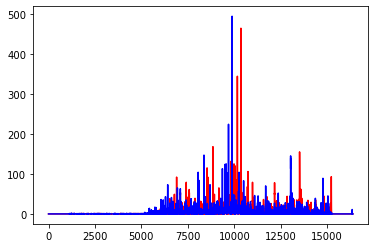

CORRELATING 0 vs -2 Shift: -477.38447850837474
saved 28June2021_G140L_interim_FP_shifts_NOdrift.txt
800 FUVB no data to shift
464.0 454.0


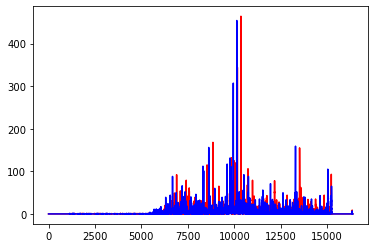

CORRELATING 0 vs -1 Shift: -221.4844407697674
saved 28June2021_G140L_interim_FP_shifts_NOdrift.txt


800 FUVB no data to shift
464.0 514.0


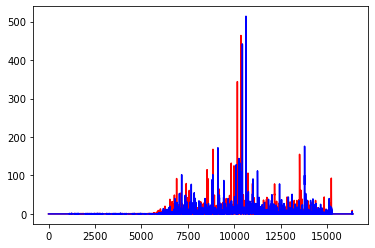

CORRELATING 0 vs 1 Shift: 269.85792206142287
saved 28June2021_G140L_interim_FP_shifts_NOdrift.txt


800 FUVB no data to shift
1055
1096
1105
1222
1230
1280
1291
1300
1309
1318
1327
1577
1589
1600
1611
1623
800
1055
1096
1105
1222
1230
1280
1291
172.0 200.0


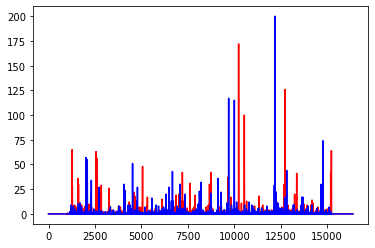

CORRELATING 0 vs -2 Shift: -536.843676900593
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
216.0 156.0


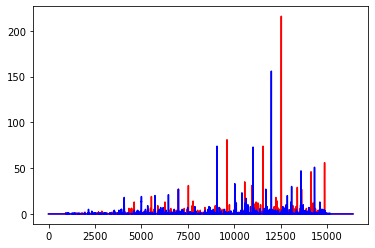

CORRELATING 0 vs -2 Shift: -537.6907415821006
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
172.0 169.0


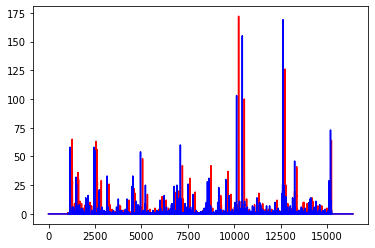

CORRELATING 0 vs -1 Shift: -108.7063086050548
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


216.0 175.0


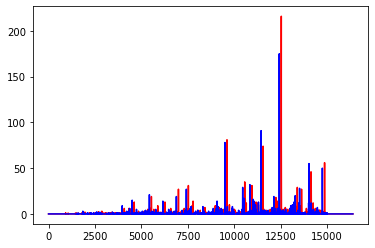

CORRELATING 0 vs -1 Shift: -108.85847184334125
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


172.0 192.0


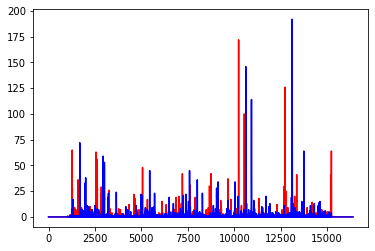

CORRELATING 0 vs 1 Shift: 385.1421781443678
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
216.0 196.0


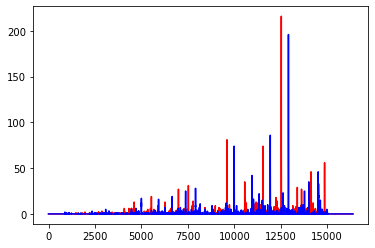

CORRELATING 0 vs 1 Shift: 385.7158557598559
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
1300
174.0 163.0


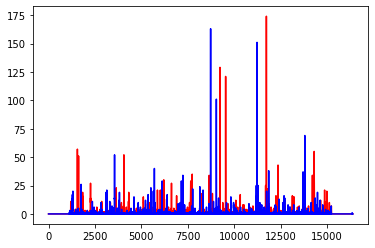

CORRELATING 0 vs -2 Shift: -503.2507206261507
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


188.0 209.0


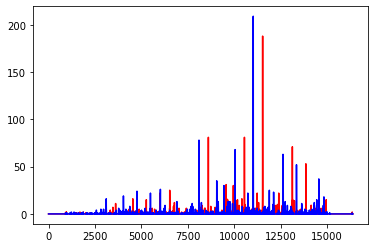

CORRELATING 0 vs -2 Shift: -504.20141672187674
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
174.0 206.0


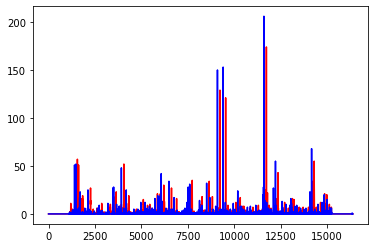

CORRELATING 0 vs -1 Shift: -135.34787760816835
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
188.0 173.0


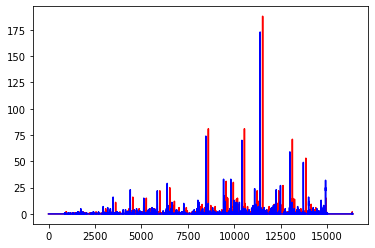

CORRELATING 0 vs -1 Shift: -135.60847098159138
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


174.0 195.0


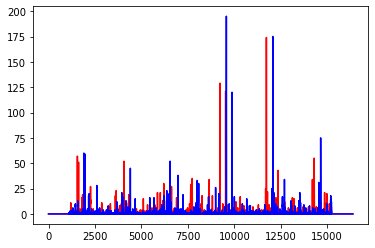

CORRELATING 0 vs 1 Shift: 345.74049873694094
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


188.0 170.0


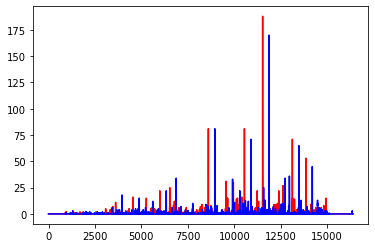

CORRELATING 0 vs 1 Shift: 347.8717270054094
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
1309


160.0 192.0


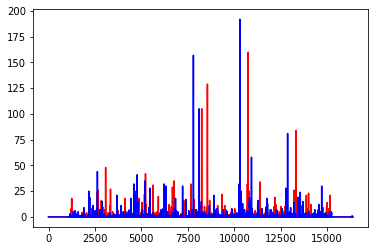

CORRELATING 0 vs -2 Shift: -445.07085424304023
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


229.0 190.0


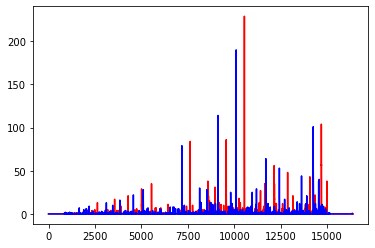

CORRELATING 0 vs -2 Shift: -443.9540776358772
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
160.0 212.0


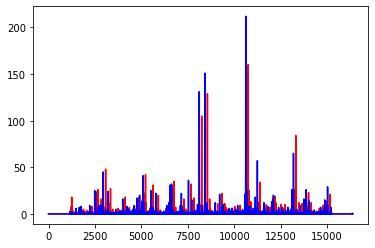

CORRELATING 0 vs -1 Shift: -128.90133213152149
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
229.0 178.0


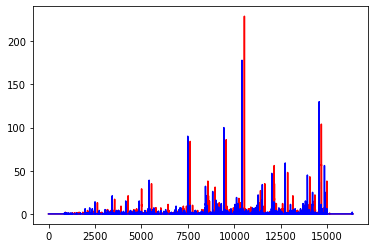

CORRELATING 0 vs -1 Shift: -128.74678831090205
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
160.0 197.0


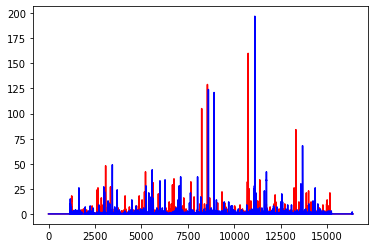

CORRELATING 0 vs 1 Shift: 360.3041825571181
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


229.0 176.0


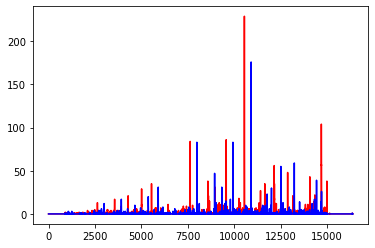

CORRELATING 0 vs 1 Shift: 360.7746800971545
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
1318
212.0 225.0


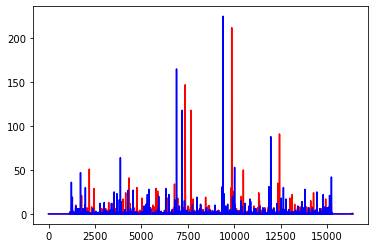

CORRELATING 0 vs -2 Shift: -469.4211196011129
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


217.0 213.0


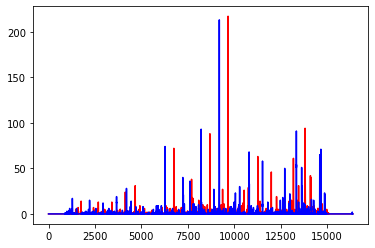

CORRELATING 0 vs -2 Shift: -470.96338697223473
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
212.0 197.0


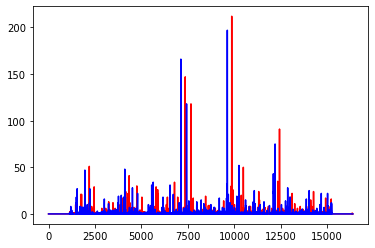

CORRELATING 0 vs -1 Shift: -237.06833461552378
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
217.0 168.0


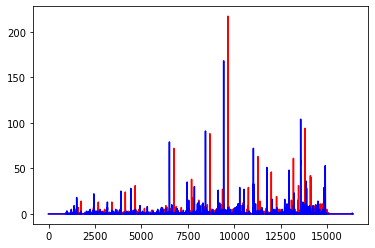

CORRELATING 0 vs -1 Shift: -237.77763269597563
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
212.0 177.0


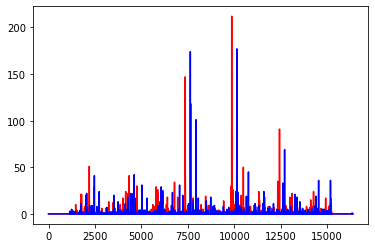

CORRELATING 0 vs 1 Shift: 273.7736465267917
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


217.0 194.0


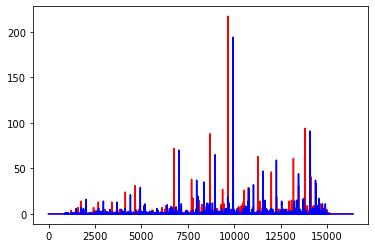

CORRELATING 0 vs 1 Shift: 274.30817885158467
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
1327


192.0 180.0


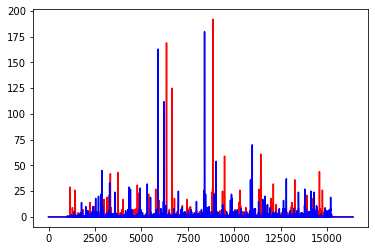

CORRELATING 0 vs -2 Shift: -453.3435081231037
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
246.0 209.0


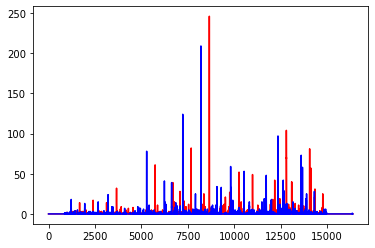

CORRELATING 0 vs -2 Shift: -453.6944545564402
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


192.0 243.0


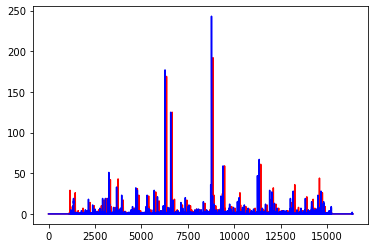

CORRELATING 0 vs -1 Shift: -80.17117377527393
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


246.0 217.0


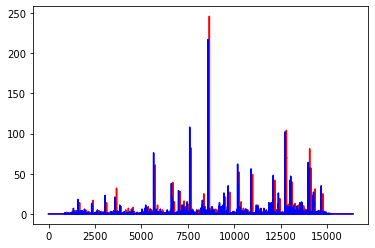

CORRELATING 0 vs -1 Shift: -80.05103722601416
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


192.0 171.0


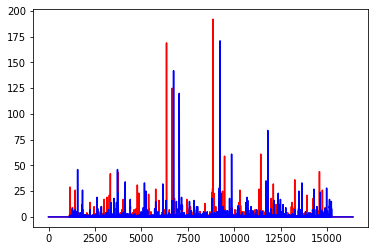

CORRELATING 0 vs 1 Shift: 381.73217754733923
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt


246.0 199.0


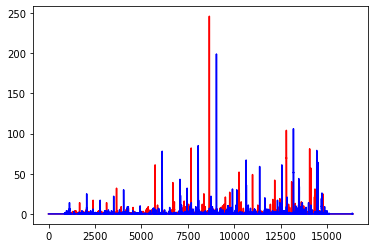

CORRELATING 0 vs 1 Shift: 381.9661020910953
saved 28June2021_G130M_interim_FP_shifts_NOdrift.txt
1533
1577
1589
1600
1611
1623


800 -2 FUVA -477.38447850837474
800 -1 FUVA -221.4844407697674
800 1 FUVA 269.85792206142287
1291 -2 FUVA -536.843676900593
1291 -2 FUVB -537.6907415821006
1291 -1 FUVA -108.7063086050548
1291 -1 FUVB -108.85847184334125
1291 1 FUVA 385.1421781443678
1291 1 FUVB 385.7158557598559
1300 -2 FUVA -503.2507206261507
1300 -2 FUVB -504.20141672187674
1300 -1 FUVA -135.34787760816835
1300 -1 FUVB -135.60847098159138
1300 1 FUVA 345.74049873694094
1300 1 FUVB 347.8717270054094
1309 -2 FUVA -445.07085424304023
1309 -2 FUVB -443.9540776358772
1309 -1 FUVA -128.90133213152149
1309 -1 FUVB -128.74678831090205
1309 1 FUVA 360.3041825571181
1309 1 FUVB 360.7746800971545
1318 -2 FUVA -469.4211196011129
1318 -2 FUVB -470.96338697223473
1318 -1 FUVA -237.06833461552378
1318 -1 FUVB -237.77763269597563
1318 1 FUVA 273.7736465267917
1318 1 FUVB 274.30817885158467
1327 -2 FUVA -453.3435081231037
1327 -2 FUVB -453.6944545564402
1327 -1 FUVA -80.17117377527393
1327 -1 FUVB -80.05103722601416
1327 1 FUVA 381.

In [11]:
# 11

# Define a name for a .txt save file.

save_file_G140L = '28June2021_G140L_interim_FP_shifts_NOdrift.txt'
find_fp_pix_shift(newlamptab_G140L, save_file_G140L, 3)

save_file_G130M = '28June2021_G130M_interim_FP_shifts_NOdrift.txt'
find_fp_pix_shift(newlamptab_G130M, save_file_G130M, 5)

# This routine is in the "make_interim_lamptab" routine.
# Saves new pixel shifts into .txt file, then we'll update the Lamp Tab file one more time
# to update those positions.

update_lamptab(save_file_G140L, newlamptab_G140L)

update_lamptab(save_file_G130M, newlamptab_G130M)


In [12]:
# 12

# Next up is to run CalCOS again!

# Changing WAVECORR to PERFORM, but everything else is the same
# from when we did this earlier.
# But also at the end, specify the new interim lamp tab file.
# Also, note that we're not changing the extract tab,
# we're using the LP3 extract tab which for cenwave 800
# has the 1105 entries.
# And we're not changing the disptab.
# Currently using LP3 disptab which has the LP4 disptab entries for c800.
#
# What is extract tab?
# has extraction region used for boxcar extraction
# rows for every grating/cenwave, segment, and aperture
# for a cenwave 800 extract tab,
# rows for all the various parameters,
# where is the spectrum landing on the detector?
# also things like slope of extraction region
# check out detector training for more details

for myfile in rawtags:
    if fits.getval(myfile, 'OPT_ELEM') == 'G140L':
        fits.setval(myfile, 'WAVECORR', value='PERFORM')
        fits.setval(myfile, 'LAMPTAB', value='28June2021_G140L_interim_lamp.fits')
    elif fits.getval(myfile, 'OPT_ELEM') == 'G130M':
        fits.setval(myfile, 'WAVECORR', value='PERFORM')
        fits.setval(myfile, 'LAMPTAB', value='28June2021_G130M_interim_lamp.fits')
        
# Because I'm setting the same set of files to calibrate, because I'm setting the
# lamptab here, it changes the default for if/when I try to run this again
# from the start.


In [13]:
# 13

# We're running CalCOS again, so let's make a new directory to put the output.
#
# And here we're just grabbing all the G140L rawtags (they're only Segment A).

rawtags_G140L = []
for myfile in rawtags_G140L:
    if fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) < 1000.:
        rawtags_G140L.append(myfile)
        
for myfile in rawtags_G140L:
    calcos.calcos(myfile, outdir='/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G140L')

# ^ Comment out running CalCOS again in case I re-run the cell, since it takes forever.


In [14]:
# 14

# We're running CalCOS again, so let's make a new directory to put the output.
#
# And here we're just grabbing all the G130M rawtags (they're both Segment A & B).

rawtags_G130M = []
for myfile in rawtags_G130M:
    if fits.getval(myfile, 'OPT_ELEM') == 'G130M' and fits.getval(myfile, 'EXPTIME', ext=1) < 1000.:
        rawtags_G130M.append(myfile)
        
for myfile in rawtags_G130M:
    calcos.calcos(myfile, outdir='/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G130M')

# ^ Comment out running CalCOS again in case I re-run the cell, since it takes forever.


In [15]:
# 15

# We're now looking at the python routine called
# "removedriftfromwavecorr.py"
# and Elaine is explaining what it does:
#
# First, set up where everything's going to go.

corrdir_G140L = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G140L'
outputdir_G140L = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G140L/corrtags_deshifted'
calcosout_G140L = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G140L/x1ds_deshifted'

import os
from removedriftfromwavecorr import *

lffiles_G140L = glob.glob(os.path.join(corrdir_G140L, '*lampflash.fits'))

# Copy+Paste from Camellia's code:

for lampflash in lffiles_G140L:
        
# open the lampflash file and grab the data and header
    with fits.open(lampflash) as df:
        lampdata = df[1].data
        lamphead = df[0].header

    cenwave = lamphead['cenwave']
    fppos = lamphead['fppos']

        # open the lamptab file and grab the data
        # this should be the interim lamptab file
    lamptab = '28June2021_G140L_interim_lamp.fits'#HERE
    with fits.open(lamptab) as lt:
        ltdata = lt[1].data

    for segment in ['FUVA', 'FUVB']:
        if (cenwave == 800) & (segment == 'FUVB'):
            continue

        shifts = lampdata[np.where(lampdata['segment'] == segment)]['SHIFT_DISP']

        wh_lt = np.where((ltdata['segment'] == segment) &
                         (ltdata['cenwave'] == cenwave) &
                         (ltdata['fpoffset'] == fppos-3) )
        fp_pixel_shift = ltdata[wh_lt]['fp_pixel_shift'][0]

        subshifts = shifts - fp_pixel_shift
        finalshifts = np.array([x - subshifts[0] for x in subshifts[1:]])

        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print('shifts found for {} {} {} = {}'.format(cenwave, fppos, segment, finalshifts))

        # if any shifts are greater than 1 pixel, remove the drift

        # if np.any(abs(finalshifts) > 1.0):

        print('correcting xcorr....')
        info, xcorr, ycorr, time = get_corrtag_info(corrdir_G140L, lampflash, segment)

        # blocks are in the format [time_on, time_off] for a single setting from the lampflash
        blocks = make_time_blocks_sec(lampflash, info)
        print(blocks)

        newxcorr = correct_xcorr_drift(time, xcorr, blocks, finalshifts)
        newcorrtagfile = write_new_corrtag(corrdir_G140L, lampflash, newxcorr, outputdir_G140L, segment)

        # else:
        #     print('no correction done')
        #     oldcorrtagfile = get_corrtag_filename(datadir, lampflash, segment)
        #     copy_xfull(oldcorrtagfile, outputdir)

newcorrtags_G140L = glob.glob(os.path.join(outputdir_G140L, '*corrtag*'))

for newcorrtag_G140L in newcorrtags_G140L:
    fits.setval(newcorrtag_G140L, 'WAVECORR', value='OMIT')

newcorrfilesa_G140L = [x for x in newcorrtags_G140L if 'corrtag_b' not in x]

for newcorrtaga_G140L in newcorrfilesa_G140L:
    make_new_x1ds(newcorrtaga_G140L, calcosout_G140L)
                    
# (Get error below because I'm trying to re-run CalCOS on data
# that's already been CalCOSed.)


In [16]:
# 16

# We're now looking at the python routine called
# "removedriftfromwavecorr.py"
# and Elaine is explaining what it does:
#
# First, set up where everything's going to go.

corrdir_G130M = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G130M'
outputdir_G130M = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G130M/corrtags_deshifted'
calcosout_G130M = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output_28June2021/G130M/x1ds_deshifted'

import os
from removedriftfromwavecorr import *

lffiles_G130M = glob.glob(os.path.join(corrdir_G130M, '*lampflash.fits'))

# Copy+Paste from Camellia's code:

for lampflash in lffiles_G130M:
        
# open the lampflash file and grab the data and header
    with fits.open(lampflash) as df:
        lampdata = df[1].data
        lamphead = df[0].header

    cenwave = lamphead['cenwave']
    fppos = lamphead['fppos']

        # open the lamptab file and grab the data
        # this should be the interim lamptab file
    lamptab = '28June2021_G130M_interim_lamp.fits'#HERE
    with fits.open(lamptab) as lt:
        ltdata = lt[1].data

    for segment in ['FUVA', 'FUVB']:
        if (cenwave == 800) & (segment == 'FUVB'):
            continue

        shifts = lampdata[np.where(lampdata['segment'] == segment)]['SHIFT_DISP']

        wh_lt = np.where((ltdata['segment'] == segment) &
                         (ltdata['cenwave'] == cenwave) &
                         (ltdata['fpoffset'] == fppos-3) )
        fp_pixel_shift = ltdata[wh_lt]['fp_pixel_shift'][0]

        subshifts = shifts - fp_pixel_shift
        finalshifts = np.array([x - subshifts[0] for x in subshifts[1:]])

        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print('shifts found for {} {} {} = {}'.format(cenwave, fppos, segment, finalshifts))

        # if any shifts are greater than 1 pixel, remove the drift

        # if np.any(abs(finalshifts) > 1.0):

        print('correcting xcorr....')
        info, xcorr, ycorr, time = get_corrtag_info(corrdir_G130M, lampflash, segment)

        # blocks are in the format [time_on, time_off] for a single setting from the lampflash
        blocks = make_time_blocks_sec(lampflash, info)
        print(blocks)

        newxcorr = correct_xcorr_drift(time, xcorr, blocks, finalshifts)
        newcorrtagfile = write_new_corrtag(corrdir_G130M, lampflash, newxcorr, outputdir_G130M, segment)

        # else:
        #     print('no correction done')
        #     oldcorrtagfile = get_corrtag_filename(datadir, lampflash, segment)
        #     copy_xfull(oldcorrtagfile, outputdir)

newcorrtags_G130M = glob.glob(os.path.join(outputdir_G130M, '*corrtag*'))

for newcorrtag_G130M in newcorrtags_G130M:
    fits.setval(newcorrtag_G130M, 'WAVECORR', value='OMIT')

newcorrfilesa_G130M = [x for x in newcorrtags_G130M if 'corrtag_b' not in x]

for newcorrtaga_G130M in newcorrfilesa_G130M:
    make_new_x1ds(newcorrtaga_G130M, calcosout_G130M)
                    
# (Get error below because I'm trying to re-run CalCOS on data
# that's already been CalCOSed.)


In [17]:
# 17

from updating_newcenwave_lamptab import *


In [18]:
# 18

import shutil

# First step, glob all the appropriate x1d files from the calcosout directory.
# These are the de-shifted x1d files.

x1dfiles_G140L = glob.glob(os.path.join(calcosout_G140L, '*_x1d.fits'))

# Copy+pasting relevant bits form Camellia's code...

new_lamp_name_G140L = "LP3_G140L_fuv_28June2021_lamp.fits"
#old_lamp_name = lampdataLP3
# ^ this is redundant

makelamptemplatefile(new_lamp_name_G140L, lampdataLP3, x1dfiles_G140L)

# getting x1d data (de-shifted), writing out to intensity
# column in the lamp tab

# dispersion files establish where the zero point of the
# wavelength solution (variable in DISPTAB is "D")
#
# disp file from LP4 from before worked okay,
# so let's look it up and download it like we did before
# but we need to know the file name!
#
# NOTE: we're going to use the LP3 disptab instead, but it has
# the solutions from LP4 in it (it'll be easier for me)
# "52j2117ml_disp.fits"

new_disp_name_G140L = "LP3_G140L_fuv_28June2021_disp.fits"
old_disp_name_G140L = "52j2117ml_disp.fits"

save_file_G140L = "LP3_G140L_final_FP_shifts_28June2021.txt"

find_fp_pix_shift(new_lamp_name_G140L, save_file_G140L)

# getting pixel shift value and writing it out to text file

update_lamptab(save_file_G140L, new_lamp_name_G140L)

# ^ this actually writes it out to the file
#
# Copy+Pasting now directly from Camellia's code:

# Updating DISPTAB
# copying the old disptab so the linear dispersion values match when the
# LP1 lamptab was created.

if os.path.exists(new_disp_name_G140L):
    y_n = input('Do you want to overwrite {}? y/n '.format(new_disp_name_G140L))
    if y_n == 'y':
        os.remove(new_disp_name_G140L)
        shutil.copy(old_disp_name_G140L, new_disp_name_G140L)
    else:
        raise ValueError("Exiting. Change DISPTAB name.")
else:
    shutil.copy(old_disp_name_G140L, new_disp_name_G140L)

update_zeropoint(new_lamp_name_G140L, lampdataLP3, new_disp_name_G140L, old_disp_name_G140L)


800
CORRELATING 0 vs -2 Shift: -517.4462813026585
saved LP3_G140L_final_FP_shifts_28June2021.txt
800 FUVB no data to shift
CORRELATING 0 vs -1 Shift: -255.17912466396228
saved LP3_G140L_final_FP_shifts_28June2021.txt
800 FUVB no data to shift
CORRELATING 0 vs 1 Shift: 235.57090234089628


saved LP3_G140L_final_FP_shifts_28June2021.txt
800 FUVB no data to shift
1055
1096
1105
1222
1230
1280
1291
1300
1309
1318
1327
1577
1589
1600
1611
1623
800 -2 FUVA -517.4462813026585
800 -1 FUVA -255.17912466396228
800 1 FUVA 235.57090234089628
Do you want to overwrite LP3_G140L_fuv_28June2021_disp.fits? y/n y
Updating DISPTAB
Updating 800/FUVA: 0.0 to 9.10040398593992e-09 
 Difference of: 9.10040398593992e-09


In [19]:
# 19

import shutil

# First step, glob all the appropriate x1d files from the calcosout directory.
# These are the de-shifted x1d files.

x1dfiles_G130M = glob.glob(os.path.join(calcosout_G130M, '*_x1d.fits'))

# Copy+pasting relevant bits form Camellia's code...

new_lamp_name_G130M = "LP5_G130M_fuv_28June2021_lamp.fits"
#old_lamp_name = lampdataLP4
# ^ this is redundant

makelamptemplatefile(new_lamp_name_G130M, lampdataLP4, x1dfiles_G130M)

# getting x1d data (de-shifted), writing out to intensity
# column in the lamp tab

# dispersion files establish where the zero point of the
# wavelength solution (variable in DISPTAB is "D")
#
# disp file from LP4 from before worked okay,
# so let's look it up and download it like we did before
# but we need to know the file name!
#
# NOTE: we're going to use the LP3 disptab instead, but it has
# the solutions from LP4 in it (it'll be easier for me)
# "52j2117ml_disp.fits"

new_disp_name_G130M = "LP5_G130M_fuv_28June2021_disp.fits"
old_disp_name_G130M = "2bj2256ml_disp.fits"
#old_disp_name_G130M = "lp4_2bj2256ml_disp.fits"

save_file_G130M = "LP5_G130M_final_FP_shifts_28June2021.txt"

find_fp_pix_shift(new_lamp_name_G130M, save_file_G130M)

# getting pixel shift value and writing it out to text file

update_lamptab(save_file_G130M, new_lamp_name_G130M)

# ^ this actually writes it out to the file
#
# Copy+Pasting now directly from Camellia's code:

# Updating DISPTAB
# copying the old disptab so the linear dispersion values match when the
# LP1 lamptab was created.

if os.path.exists(new_disp_name_G130M):
    y_n = input('Do you want to overwrite {}? y/n '.format(new_disp_name_G130M))
    if y_n == 'y':
        os.remove(new_disp_name_G130M)
        shutil.copy(old_disp_name_G130M, new_disp_name_G130M)
    else:
        raise ValueError("Exiting. Change DISPTAB name.")
else:
    shutil.copy(old_disp_name_G130M, new_disp_name_G130M)

update_zeropoint(new_lamp_name_G130M, lampdataLP4, new_disp_name_G130M, old_disp_name_G130M)


800


CORRELATING 0 vs -2 Shift: -485.1040681539416
saved LP5_G130M_final_FP_shifts_28June2021.txt
800 FUVB no data to shift
CORRELATING 0 vs -1 Shift: -214.0634501637578
saved LP5_G130M_final_FP_shifts_28June2021.txt
800 FUVB no data to shift
CORRELATING 0 vs 1 Shift: 277.24115310238994
saved LP5_G130M_final_FP_shifts_28June2021.txt


800 FUVB no data to shift
1055
1096
1105
1222
1230
1280
1291
1300
1309
1318
1327
1533
CORRELATING 0 vs -2 Shift: -511.38975830160416
saved LP5_G130M_final_FP_shifts_28June2021.txt
CORRELATING 0 vs -2 Shift: -512.7503466331691
saved LP5_G130M_final_FP_shifts_28June2021.txt


CORRELATING 0 vs -1 Shift: -258.88262924848823
saved LP5_G130M_final_FP_shifts_28June2021.txt
CORRELATING 0 vs -1 Shift: -258.9574283735419
saved LP5_G130M_final_FP_shifts_28June2021.txt
CORRELATING 0 vs 1 Shift: 235.75733130132903
saved LP5_G130M_final_FP_shifts_28June2021.txt


CORRELATING 0 vs 1 Shift: 236.86762622772403
saved LP5_G130M_final_FP_shifts_28June2021.txt
1577
1589
1600
1611
1623
800 -2 FUVA -485.1040681539416
No shift for 800/-2/FUVB
800 -1 FUVA -214.0634501637578
No shift for 800/-1/FUVB
800 1 FUVA 277.24115310238994
No shift for 800/1/FUVB
1533 -2 FUVA -511.38975830160416
1533 -2 FUVB -512.7503466331691
1533 -1 FUVA -258.88262924848823
1533 -1 FUVB -258.9574283735419
1533 1 FUVA 235.75733130132903
1533 1 FUVB 236.86762622772403
Do you want to overwrite LP5_G130M_fuv_28June2021_disp.fits? y/n y
Updating DISPTAB
Updating 800/FUVA: 0.0 to 9.105860954150558e-09 
 Difference of: 9.105860954150558e-09
Updating 1533/FUVA: 0.0 to 9.107679943554103e-09 
 Difference of: 9.107679943554103e-09
Updating 1533/FUVB: 0.0 to 9.104041964747012e-09 
 Difference of: 9.104041964747012e-09


In [20]:
# 20

# From the above cell we have updated DISPTAB
#
# This is the end of Elaine's checklist!
# I can do a fitsdiff to see what was updated
# My deliverables will be the new _lamp.fits files
# one each for LP3 and LP5
# and also I'll send that plus the _disp.fits file(s) to Rachel at some point
#